In [1]:
'''
04_influence.ipynb
Calculate influence metrices - infl_dist, infl_sum, infl_reg
'''

import requests
import urllib.request
import pathlib
import os
import pandas as pd
import geopandas as gpd
import numpy as np
import shapely
from shapely import wkt
from shapely.geometry import Point, Polygon, LineString, MultiPoint
from math import radians, cos, sin, asin, sqrt
import folium
import geojson
import gdal
import h3
from geovoronoi import voronoi_regions_from_coords
from geovoronoi.plotting import subplot_for_map, plot_voronoi_polys_with_points_in_area
import matplotlib.pyplot as plt
import geoplot.crs as gcrs
import geoplot as gplt
import seaborn as sns

tiles = {
  	"url": "https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png", 
	"attribution": '',
}

DIR_ROOT = os.path.join(pathlib.Path().absolute(), '../../..' )
DIR_DATA = DIR_ROOT + '/data/04_itinerary/'
DIR_OUT = DIR_ROOT + '/data/05_metrics/'

influences_df = pd.read_csv(DIR_DATA + 'influences.csv')
influences_df = influences_df[influences_df['domestic'] == True]

stays_df = pd.read_csv(DIR_DATA + 'stays.csv')
stays_df['geometry'] = stays_df['geometry'].apply(wkt.loads)
stays_df.set_index('locality', inplace=True)
stays_df['locality'] = stays_df.index

stays_geo = gpd.GeoDataFrame(stays_df, crs='epsg:4326').set_geometry('geometry')

localities = stays_geo[stays_geo['domestic'] == True].groupby(level=0).first()
localities['name'] = localities.index

influences_df['geometry'] = influences_df['geometry'].apply(wkt.loads)
influences_df['geometry_source'] = influences_df['geometry_source'].apply(wkt.loads)

bbox = stays_geo.buffer(1).total_bounds

def create_map():
    m = folium.Map(tiles='Stamen Toner', dragging=False, zooming=False)

    m.fit_bounds([[bbox[1], bbox[0]], [bbox[3], bbox[2]]])
    return m

def create_circle(radius, geometry, tooltip):
    return folium.CircleMarker(
        radius=radius,
        location=[geometry.y, geometry.x], 
        tooltip=tooltip,   
        weight=1,
        color="red",
        fill="red",
    )


# Calculates distance between 2 GPS coordinates
def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

/home/adam/anaconda3/envs/po2/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
<ipython-input-1-83d578fffc9c>:71: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  bbox = stays_geo.buffer(1).total_bounds


/home/adam/anaconda3/envs/po2/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


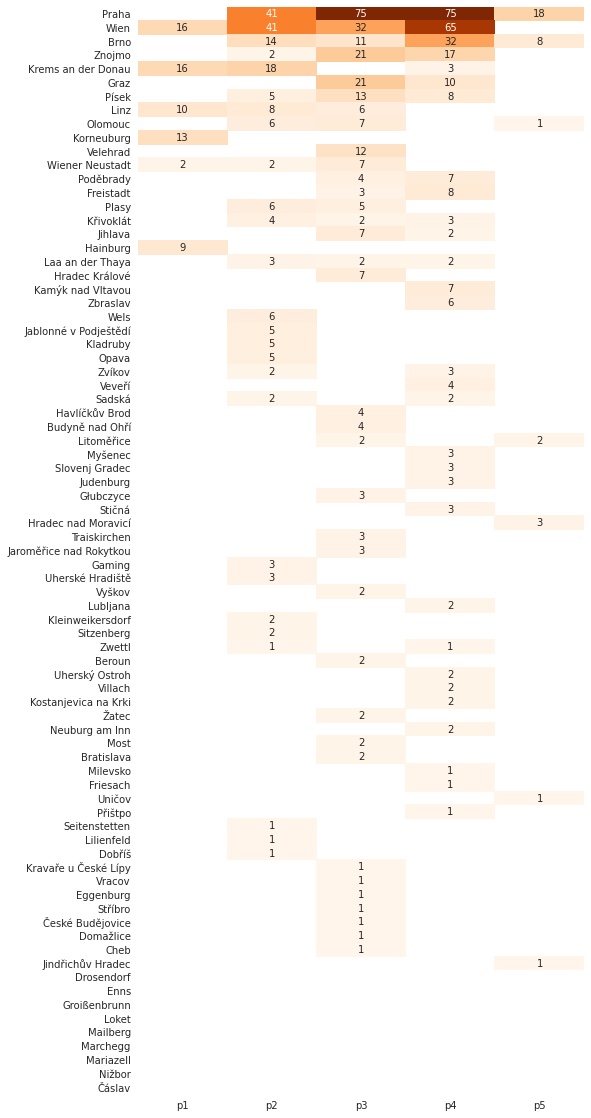

In [2]:
# infl_sum

p1 = pd.DataFrame(influences_df[influences_df['period'] == 1]['locality'].value_counts())
p2 = pd.DataFrame(influences_df[influences_df['period'] == 2]['locality'].value_counts())
p3 = pd.DataFrame(influences_df[influences_df['period'] == 3]['locality'].value_counts())
p4 = pd.DataFrame(influences_df[influences_df['period'] == 4]['locality'].value_counts())
p5 = pd.DataFrame(influences_df[influences_df['period'] == 5]['locality'].value_counts())
pall = pd.DataFrame(influences_df['locality'].value_counts())

p1.columns = ['p1']
p2.columns = ['p2']
p3.columns = ['p3']
p4.columns = ['p4']
p5.columns = ['p5']
pall.columns = ['pall']

infl_sum = gpd.GeoDataFrame(
    pd.concat([p1, p2, p3, p4, p5, pall, localities['geometry']], axis=1, join="outer"),
    crs='epsg:4326'
).sort_values(by='pall',ascending=False)

infl_sum.to_csv(DIR_OUT + 'infl_sum.csv')

fig, ax = plt.subplots(figsize = (8, 20)) 
sns.heatmap(infl_sum[['p1', 'p2', 'p3', 'p4', 'p5']], cmap ='Oranges', annot = True, cbar=False, fmt=".0f")

m = create_map()

for location_name, r in infl_sum.iterrows():
    create_circle(
        r['pall'] / 20 + 3, r['geometry'], 
        '{}: {}'.format(location_name, r['pall'])
    ).add_to(m)
m

<ipython-input-9-41b3832849b8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  influences_df_certain['distance'] = influences_df_certain.apply(
/home/adam/anaconda3/envs/po2/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


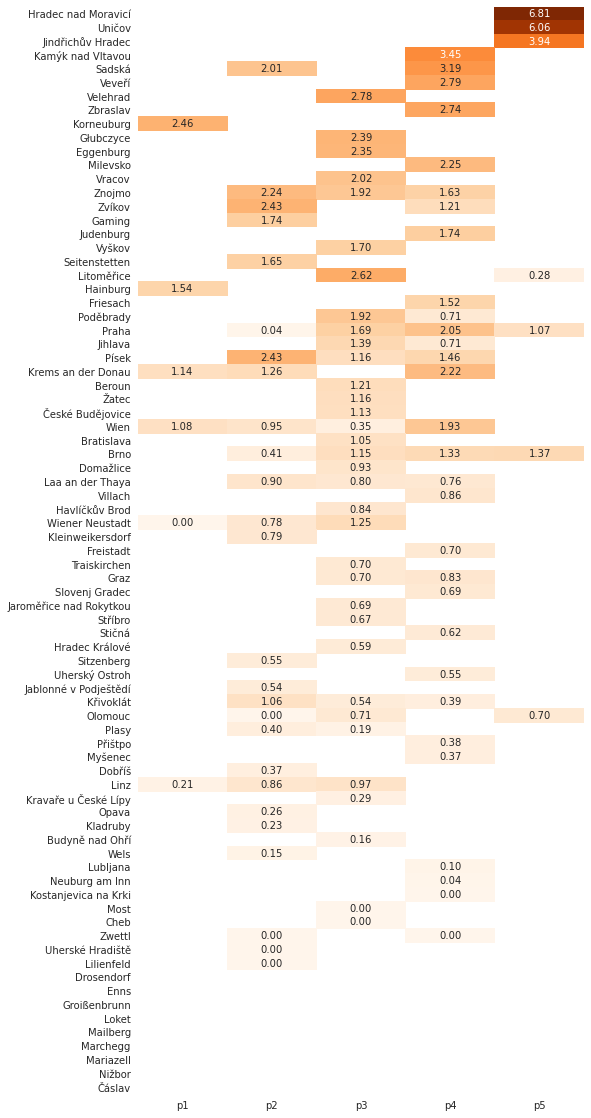

In [9]:
# infl_dist

influences_df_certain = influences_df[influences_df['certainty'] == 1]

influences_df_certain['distance'] = influences_df_certain.apply(
    lambda x: x['geometry'].distance(x['geometry_source']), axis = 1
    #lambda x: haversine(x['geometry'].x, x['geometry'].y, x['geometry_source'].x, x['geometry_source'].y), axis = 1
)

p1 = pd.DataFrame(influences_df_certain[influences_df_certain['period'] == 1].groupby(['locality']).median()['distance'])
p2 = pd.DataFrame(influences_df_certain[influences_df_certain['period'] == 2].groupby(['locality']).median()['distance'])
p3 = pd.DataFrame(influences_df_certain[influences_df_certain['period'] == 3].groupby(['locality']).median()['distance'])
p4 = pd.DataFrame(influences_df_certain[influences_df_certain['period'] == 4].groupby(['locality']).median()['distance'])
p5 = pd.DataFrame(influences_df_certain[influences_df_certain['period'] == 5].groupby(['locality']).median()['distance'])
pall = pd.DataFrame(influences_df_certain.groupby(['locality']).median()['distance'])

p1.columns = ['p1']
p2.columns = ['p2']
p3.columns = ['p3']
p4.columns = ['p4']
p5.columns = ['p5']
pall.columns = ['pall']

infl_dist = gpd.GeoDataFrame(
    pd.concat([p1, p2, p3, p4, p5, pall, localities['geometry']], axis=1, join="outer"),
    crs='epsg:4326'
).sort_values(by='pall',ascending=False)

infl_dist.to_csv(DIR_OUT + 'infl_dist.csv')

fig, ax = plt.subplots(figsize = (8, 20)) 
sns.heatmap(infl_dist[['p1', 'p2', 'p3', 'p4', 'p5']], cmap ='Oranges', annot = True, cbar=False, fmt=".2f")

m = create_map()

for location_name, r in infl_dist.iterrows():
    create_circle(
        r['pall'] * 3 + 2, r['geometry'], 
        '{}: {}'.format(location_name, r['pall'])
    ).add_to(m)
m

In [4]:
bounds = Polygon([
    [bbox[0], bbox[1]], 
    [bbox[0], bbox[3]], 
    [bbox[2], bbox[3]], 
    [bbox[2], bbox[1]]])

region_polys, region_pts = voronoi_regions_from_coords(localities['geometry'], bounds)

INFO:geovoronoi:running Voronoi tesselation for 79 points / treating geoms separately: True
INFO:geovoronoi:79 of 79 points in geometry #1 of 1
INFO:geovoronoi:generating Voronoi regions
INFO:geovoronoi:generating Voronoi region polygons
INFO:geovoronoi:collecting Voronoi region results


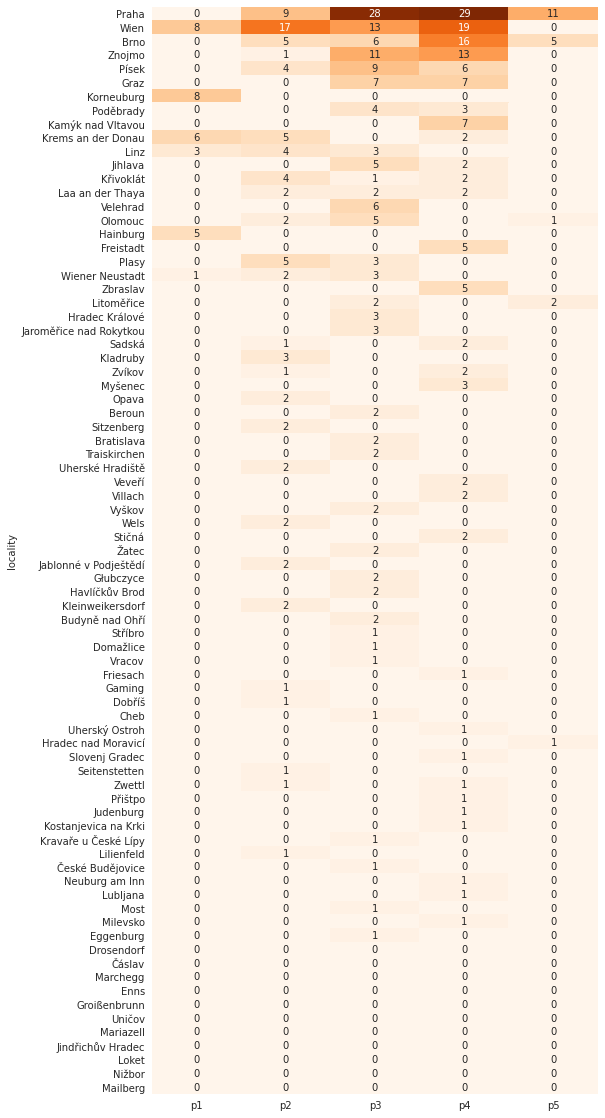

In [5]:
# infl_reg

periods = ['1', '2', '3', '4', '5', 'all']

infl_reg = gpd.GeoDataFrame(localities['geometry'])


for period in periods:
    period_influences = influences_df_certain if period == 'all' else influences_df_certain[influences_df_certain['period'] == int(period)]

    for localityname, locality in localities.iterrows():
        locality_influences = period_influences[period_influences['locality'] == localityname]
        region_ids = []

        for i, influence in locality_influences.iterrows():
            inf_dest_geom = influence['geometry']
            #region_polys.
            #print(localityname, influence['name'], inf_dest_geom)

            for region in region_polys.items():
                region_geo = region[1]
                region_id = region[0]
                if region_geo.contains(inf_dest_geom):
                    region_ids.append(region_id)

        region_no = len(np.unique(region_ids))
        infl_reg.at[localityname, 'p' + period] = region_no

infl_reg.sort_values(by='pall',ascending=False, inplace=True)

infl_reg.to_csv(DIR_OUT + 'infl_reg.csv')

fig, ax = plt.subplots(figsize = (8, 20)) 
sns.heatmap(infl_reg[['p1', 'p2', 'p3', 'p4', 'p5']], cmap ='Oranges', annot = True, cbar=False, fmt=".0f")

m = create_map()

for location_name, r in infl_reg.iterrows():
    create_circle(
        r['pall'] + 2, r['geometry'], 
        '{}: {}'.format(location_name, r['pall'])
    ).add_to(m)
m